# Initialisation

In [1]:
import os

import re
import sys
import time
import math
import random
import pickle
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import scipy.stats as stat 
import statsmodels.api as sm
import seaborn as sns
import matplotlib.cm as cmap #Importing colormap
sns.set()

from pytz import timezone
from datetime import datetime
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression 
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from skimage.io import imread
from pathlib import Path
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.linear_model import LinearRegression

def SaveVariable(Variable, FileName):
    '''
    Saved any variable to the local drive
    '''
    DirName = Path(FileName).parent.absolute()
    os.makedirs(DirName, exist_ok = True)

    with open(FileName, 'wb') as io:
        pickle.dump(Variable, io)
    
def LoadVariable(FileName):
    '''
    Loads a variable from the local drive
    '''
    with open(FileName, "rb") as io:
        Res = pickle.load(io)
    return Res

def NpShift(arr, num, fill_value = np.nan):
    '''
    Shifts a numpy array by 'num' places
    '''
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

def NxDtoN2xTxD(X_Data, T):
    '''
    Transforms an NxD matrix to an (N-T)xTxD tensor
    '''
    if T != 0:
        tmp = X_Data
        X_Data = X_Data.reshape(-1, 1, X_Data.shape[1])
        for t in range(T):
            X_Data = np.concatenate((NpShift(tmp, t+1)[:, np.newaxis, :], X_Data), axis = 1)
        if T > 0:
            Y_Data = X_Data[T:, -1, :]
            X_Data = X_Data[T:, :-1, :]
        else:
            Y_Data = X_Data[:T, -1, :] #T is already negative
            X_Data = X_Data[:T, :-1, :] #T is already negative
        return X_Data, Y_Data
    
    else:
        print("NxDtoN2xTxD:", "T [{T}] can't be zero")
        return X_Data, None

def GetAndShowShapes(SupervisedType, YisX, X, Y, X_Train, Y_Train, X_Test, Y_Test, TrainDataset, train_loader, RowsToShow = 5):
    '''
    Retrieves the relevant shapes from the dataset and prints them
    '''
    SupervisedType = SupervisedType.lower()
    
    if X_Train is not None:
        print(f"X_Train[:{RowsToShow}]:\n", X_Train[:RowsToShow])
    else:
        print(f"X[:{RowsToShow}]:\n", X[:RowsToShow])        
    print()
    
    # number of classes
    if Y is not None:
        K = len(set(Y)) if SupervisedType == "classification" and len(set(Y)) != 2 else (Y.shape[1] if SupervisedType == "multivariateregression" else 1) #An output_size (K) > 1 can be either Multiclass or Multivariate-Regression, like Lat/Lon coordinates
    elif Y_Train is not None:
        K = len(set(Y_Train)) if SupervisedType == "classification" and len(set(Y_Train)) != 2 else (Y_Train.shape[1] if SupervisedType == "multivariateregression" else 1)
    elif YisX == True:    # When we Forecast and data is NxD, only later to be transformed to NxTxD,
        if X is not None: # Y is the latest/newest row of X, i.e. Y comes from X, there is no Y.
            K = X.shape[1]
        elif X_Train is not None:
            K = X_Train.shape[1]
        
    if len(X_Train.shape) == 2:
        N, D = X_Train.shape if X_Train is not None else X.shape
        H1, W1 = (0, 0)
    elif len(X_Train.shape) == 3:
        D = 0
        N, H1, W1 = X_Train.shape if X_Train is not None else X.shape
    elif len(X_Train.shape) == 4:
        N, H1, W1, D = X_Train.shape if X_Train is not None else X.shape
    
    if X is not None and Y is not None:
        print("X.shape      ", X.shape, "Y.shape      ", Y.shape)
    elif X is not None:
        print("X.shape      ", X.shape)
    if X_Train is not None and Y_Train is not None:
        print("X_Train.shape", X_Train.shape, "Y_Train.shape", Y_Train.shape)
    elif X_Train is not None:
        print("X_Train.shape", X_Train.shape)
    if X_Test is not None and Y_Test is not None:
        print("X_Test.shape ", X_Test.shape, "Y_Test.shape ", Y_Test.shape)
    elif X_Test is not None:
        print("X_Test.shape ", X_Test.shape)
    if X is not None:
        print(f"X: min = {X.min():.4f}, max = {X.max():.4f}")
    if X_Train is not None:
        print(f"X_Train: min = {X_Train.min():.4f}, max = {X_Train.max():.4f}")
    print("K         ", K)
    print("N:", N, "H1:", H1, "W1:", W1, "D:", D)

    if TrainDataset is not None:
        print(f"\nTrainDataset length: {len(TrainDataset)}")
        print(f"Data after transformation with batch size = {batch_size}:")
        if train_loader is not None:
            tmpX, tmpY = next(iter(train_loader))
            print("X.shape", tmpX.shape, "\tY.shape", tmpY.shape)

        #Sanity check:
        assert np.allclose(TrainDataset.__getitem__(0)[0][0], X_Train[0])
    
    return K, N, D, H1, W1

def PlotEachVarInX(X_Series):
    '''
    Plots a Pandas Series variable
    '''
    X_Series.plot()
    plt.ylabel(X_Series.name)
    plt.show()

def PlotEachLagVarInX(X_Series, lag = 1):
    '''
    Plots a lag_plot of a Pandas Series variable
    '''
    lag_plot(X_Series, lag = lag)
    plt.title(X_Series.name)
    plt.show()
    
def Var_LagVar_Cor(X_Series, lag = 1):
    '''
    Returns the correlation of a Pandas Series with its lagged version
    '''
    tmp = pd.concat([X_Series.shift(lag), X_Series], axis = 1)
    tmp.columns = [f't{int(math.copysign(lag, lag) * (-1))}', 't']
    return tmp.corr()

def PlotAutocorrelation(X_Series):
    '''
    Plots the autocorrelation_plot from Pandas on a Pandas Series
    '''
    pd.plotting.autocorrelation_plot(X_Series)
    plt.title(X_Series.name)
    plt.show()

def PlotAutocorrelationLineplot(X_Series, MaxLag = 31):
    '''
    Plots an autocorrelation line plots
    '''
    plot_acf(X_Series, lags = MaxLag)
    plt.title(X_Series.name)
    plt.xlabel("lag")
    plt.ylabel("Autocorrelation")
    plt.show()
    
def init_seeds(seed):
    '''
    Initialises the seeds in imported packages for reproducibility
    '''
    random.seed(seed)
    np.random.seed(seed)

# Data

In [2]:
#Setting the root directory / working directory
path_root = f"{os.getcwd()}"
print(path_root)

C:\Users\31636\OneDrive\Desktop\Thesis Data


Rented Bike Count              int64
Temperature(�C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(�C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Seasons                       object
Holiday                       object
Functioning Day               object 

Using saved scaler.
X_Train[:0]:
 []

X.shape       (8760, 1)
X_Train.shape (7784, 100, 1) Y_Train.shape (7784, 1)
X_Test.shape  (776, 100, 1) Y_Test.shape  (776, 1)


C:\Users\31636\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


X: min = 0.0000, max = 3556.0000
X_Train: min = -1.0732, max = 4.3164
K          1
N: 7784 H1: 100 W1: 1 D: 0

Plotting the Dependent Variables:


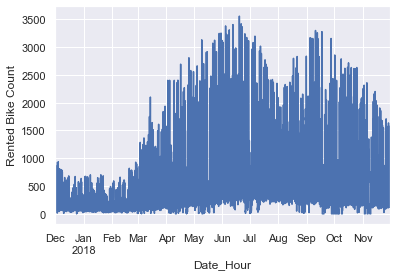

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Plotting the lag-transformed Dependent Variables:


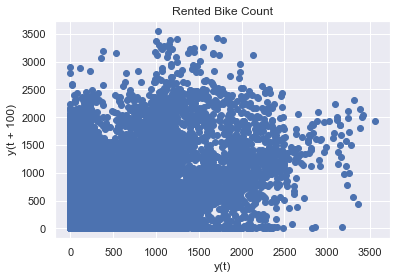


Correlation between Variable and its lag-counterpart:
Rented Bike Count
          t-100         t
t-100  1.000000  0.360102
t      0.360102  1.000000 


Plotting Autocorrelation:


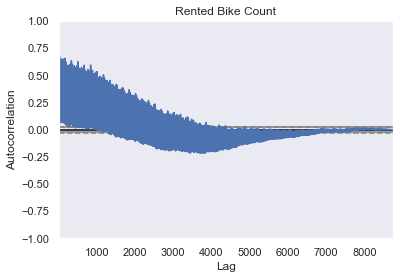


Plotting Autocorrelation line plot:


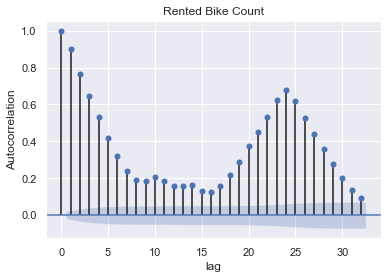

Rented Bike Count    None
dtype: object

In [12]:
#############################
### Data Hyperparameters ####
Seed = 42 #The answer to Life, the Universe, and Everything.
CustomNAString = None #If missing values are encoded with a string, which is the string?
T = 100 #The Sequence length for NxTxD transformation of an NxD dataset
#############################


#################
### One File ###
XY = pd.read_csv(f"{path_root}/Data/sb_data.csv", header = 0, parse_dates=[['Date', 'Hour']])
XY["Date_Hour"] = pd.to_datetime(XY["Date_Hour"], format="%d/%m/%Y %H")
XY = XY.set_index(["Date_Hour"]) #XY = XY.reset_index()
#################


##########################
### Viewing the dtypes ###
print(XY.dtypes.to_string(), "\n")
##########################


####################
### Handling NAs ###
NBeforeNADrop = len(XY)
XY = XY.dropna()
DroppedNARows = NBeforeNADrop - len(XY)
if DroppedNARows > 0: print("Dropped NA rows count:", DroppedNARows)

if CustomNAString is not None:
    NBeforeCustomNADrop = len(XY)
    XY = XY.replace(CustomNAString, np.nan, regex = False).dropna()
    DroppedCustomNARows = NBeforeCustomNADrop - len(XY)
    if DroppedCustomNARows > 0: print("Dropped custom NA rows count:", DroppedCustomNARows)
####################


################################
### Getting a Train/Test set ###
ColumnsToKeepX = ["Rented Bike Count"] #Columns to keep
X = XY[ColumnsToKeepX].values.astype(float) #Keeping those columns

N = X.shape[0] #N number of observations

TrainPerc = 0.9 #Training set is 90% of the data
init_seeds(Seed) #Ensuring reproducibility
X_Train = X[:int(N * TrainPerc)] #Creating Training set
X_Test = X[int(N * TrainPerc):]  #Creating Test set
################################


########################
### Scaling the Data ###
if os.path.exists(f"{path_root}/Models/scaler"): #If the file already exists, load it
    print("Using saved scaler.")
    scaler = LoadVariable(f"{path_root}/Models/scaler")
    X_Train = scaler.transform(X_Train)
else:                                            #Otherwise perform a new scaling and save it to the hard drive
    scaler = StandardScaler(with_mean = True, with_std = True)
    X_Train = scaler.fit_transform(X_Train)
    SaveVariable(scaler, f"{path_root}/Models/scaler")
X_Test = scaler.transform(X_Test)
########################


###################################
### Transform from NxD to NxTxD ###
X_Train, Y_Train = NxDtoN2xTxD(X_Train, T) #Transforming from NxD to NxTxD
X_Test, Y_Test = NxDtoN2xTxD(X_Test, T) #Transforming from NxD to NxTxD
###################################


#Getting the K number of outputs, NTrain number of observations on training set, and D dimensions of X input
K, NTrain, D, _, _ = GetAndShowShapes("Regression", True, X, None, X_Train, Y_Train, X_Test, Y_Test, None, None, RowsToShow = 0)

lag = T
MaxAutocorrelationLag = 32

print("\nPlotting the Dependent Variables:")
XY[ColumnsToKeepX].apply(PlotEachVarInX)

print("\nPlotting the lag-transformed Dependent Variables:")
XY[ColumnsToKeepX].apply(PlotEachLagVarInX, lag = lag)

print("\nCorrelation between Variable and its lag-counterpart:")
for i in range(len(ColumnsToKeepX)):
    print(ColumnsToKeepX[i])
    print(Var_LagVar_Cor(XY[ColumnsToKeepX].iloc[:, i], lag = lag), "\n")

print("\nPlotting Autocorrelation:")
XY[ColumnsToKeepX].apply(PlotAutocorrelation)

print("\nPlotting Autocorrelation line plot:")
XY[ColumnsToKeepX].apply(lambda x: PlotAutocorrelationLineplot(x, MaxLag = MaxAutocorrelationLag))

# Model

## Naive Model

In [13]:
#This is the baseline model.
#It's naive and its predictions are the values it gets as input
class NaiveModel():
    def __init__(self):
        pass
        
    def predict(self, X):
        return X[:, -1, :]

MSE: 82308.39690721649


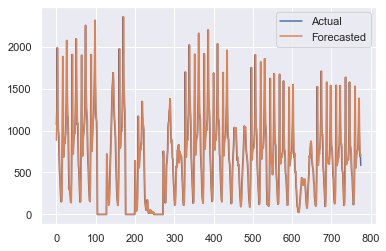

Var 1, r2: 0.66,  MAE: 180.6907

Overall Rsquare: 0.66

Actual Values:
[[1069.]
 [1274.]
 [1987.]
 [1377.]
 [1026.]]
Predic Values:
[[ 884.]
 [1069.]
 [1274.]
 [1987.]
 [1377.]]


In [14]:
naive_model = NaiveModel() #Instantiating the model

naive_predictions = naive_model.predict(X_Test) #Making predictions

Targets = Y_Test.copy() #Making copies because we'll inverse-transform from scaler to go back to original values
Predictions = naive_predictions.copy() #Making copies because we'll inverse-transform from scaler to go back to original values

if "scaler" in locals() or "scaler" in globals(): #If we use a scaler, let's inverse-transform
    Targets = scaler.inverse_transform(Targets)
    Predictions = scaler.inverse_transform(Predictions)

for i in range(Targets.shape[1]):
    Cur_Target = Targets[:, i] #Current targets
    Cur_Predic = Predictions[:, i] #Current predictions
    Cur_Residu = Cur_Target - Cur_Predic #current residuals
    print(f"MSE: {(Cur_Residu.dot(Cur_Residu)) / len(Cur_Residu)}")
    plt.plot(Cur_Target, label = f"Actual")
    plt.plot(Cur_Predic, label = f"Forecasted")
    plt.legend()
    plt.show()
    
r2s = []
for i in range(Targets.shape[1]): #Calculating R-square metric from its formula
    d1 = Targets[:, i] - Predictions[:, i]
    d2 = Targets[:, i] - Targets[:, i].mean()
    r2 = 1 - d1.dot(d1) / d2.dot(d2)
    r2s.append(r2)
    
    print(f"Var {i+1}, r2: {r2:.2f},  MAE: {np.mean(abs(d1)):.4f}")

test_r2 = np.mean(r2s)
print(f"\nOverall Rsquare: {test_r2:.2f}")

print()
print(f"Actual Values:\n{np.round(Targets[:5], 2)}")
print(f"Predic Values:\n{np.round(Predictions[:5], 2)}")

## Autoregressive Model

In [15]:
#Instantiating the model and training it
model = LinearRegression(fit_intercept = True, normalize = False).fit(X_Train.squeeze(), Y_Train)
Pred = model.predict(X_Test.squeeze()) #Making predictions

print(f"Intercept: {model.intercept_}\n    Slope: {model.coef_}\n")

Intercept: [0.00105466]
    Slope: [[ 4.37533395e-03 -2.73877471e-02  5.82238916e-02 -1.63923738e-01
   1.15712197e-01  3.26622213e-02  1.53991489e-02  1.50230724e-02
  -2.81707536e-02  3.61295613e-02 -3.08663981e-02  2.28170889e-02
  -2.68729538e-03 -2.77970711e-02  3.32897114e-02  8.21427833e-03
  -1.33189263e-02  5.45293535e-03 -7.90765812e-03 -1.63594458e-02
   2.00389171e-02 -3.44228702e-02  2.84239844e-02  1.60499400e-02
  -2.13238245e-03 -4.99135848e-02  6.64092313e-02 -1.34325705e-01
   1.28002075e-01 -8.77025188e-03 -1.75244267e-02  3.57721611e-02
  -1.45753017e-02 -1.09437485e-02 -6.22744441e-03  3.71320568e-02
  -4.04912886e-02 -1.25388276e-02  1.56490435e-02  7.11466011e-03
   6.97628395e-03  1.42853460e-02 -4.85357571e-02  4.21432099e-03
   1.39024524e-02 -1.38615817e-02  8.20375556e-03  4.11761067e-02
  -4.92531527e-02  3.01418136e-03  2.76852934e-02 -1.14083457e-01
   1.04661974e-01 -4.13654737e-03  1.12160913e-02  4.50706894e-02
  -4.47339140e-02 -1.58482208e-02  5.3098

MSE: 31438.15613290994


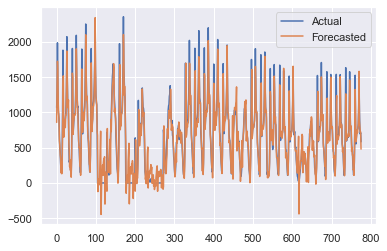

Var 1, r2: 0.87,  MAE: 118.3506

Overall Rsquare: 0.87

Actual Values:
[[1069.]
 [1274.]
 [1987.]
 [1377.]
 [1026.]]
Predic Values:
[[ 858.85]
 [1394.47]
 [1725.24]
 [1610.61]
 [1123.14]]


In [16]:
Targets = Y_Test.copy()
Predictions = Pred.copy()

if "scaler" in locals() or "scaler" in globals():
    Targets = scaler.inverse_transform(Targets)
    Predictions = scaler.inverse_transform(Predictions)

for i in range(Targets.shape[1]):
    Cur_Target = Targets[:, i] #Current targets
    Cur_Predic = Predictions[:, i] #Current predictions
    Cur_Residu = Cur_Target - Cur_Predic #current residuals
    print(f"MSE: {(Cur_Residu.dot(Cur_Residu)) / len(Cur_Residu)}")
    plt.plot(Cur_Target, label = f"Actual")
    plt.plot(Cur_Predic, label = f"Forecasted")
    plt.legend()
    plt.show()
    
r2s = []
for i in range(Targets.shape[1]): #Calculating R-square metric from its formula
    d1 = Targets[:, i] - Predictions[:, i]
    d2 = Targets[:, i] - Targets[:, i].mean()
    r2 = 1 - d1.dot(d1) / d2.dot(d2)
    r2s.append(r2)
    
    print(f"Var {i+1}, r2: {r2:.2f},  MAE: {np.mean(abs(d1)):.4f}")

test_r2 = np.mean(r2s)
print(f"\nOverall Rsquare: {test_r2:.2f}")

print()
print(f"Actual Values:\n{np.round(Targets[:5], 2)}")
print(f"Predic Values:\n{np.round(Predictions[:5], 2)}")